In [ ]:

%pip install -q pandas numpy matplotlib seaborn wordcloud nltk tensorflow scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer

warnings.filterwarnings("ignore")

nltk.download('punkt')       
nltk.download('stopwords')   
nltk.download('wordnet')



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package punkt to /Users/sankalp/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sankalp/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/sankalp/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [106]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

In [107]:
train.head()
train.columns=['polarity','title','text']
test.columns=['polarity','title','text']
train['polarity'] = train['polarity'].replace({1: 0, 2: 1})
test['polarity'] = test['polarity'].replace({1: 0, 2: 1})
train['text'].isnull().sum(), test['text'].isnull().sum()


(np.int64(0), np.int64(0))

In [108]:
train['polarity'].value_counts()

polarity
0    1800000
1    1799999
Name: count, dtype: int64

**Some Quick EDA**

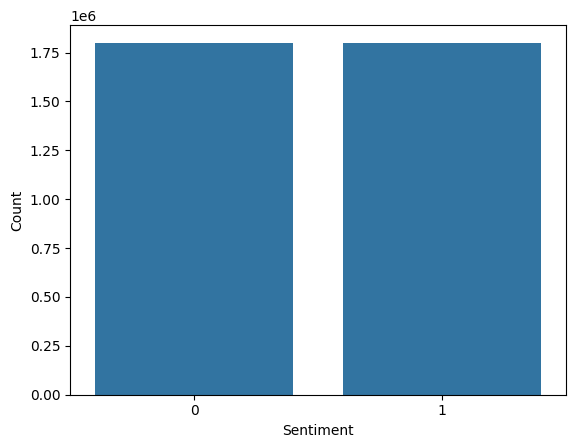

In [109]:
sns.countplot(data=train,x='polarity')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

Text(0, 0.5, 'Frequency')

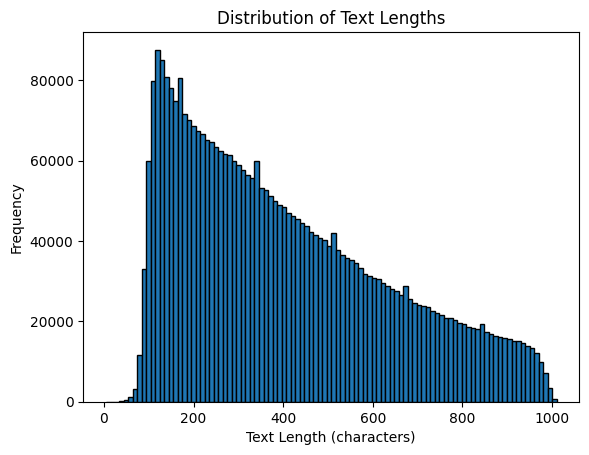

In [110]:
train['length']=train['text'].apply(len)
train['length'].plot(bins=100,kind='hist',edgecolor='black')
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length (characters)')
plt.ylabel('Frequency')

In [111]:
negative= train[train['polarity']==0]
print(negative)

         polarity                                    title  \
5               0                             Buyer beware   
9               0                               The Worst!   
12              0                                Oh please   
13              0                     Awful beyond belief!   
14              0  Don't try to fool us with fake reviews.   
...           ...                                      ...   
3599993         0                           Too simplistic   
3599994         0                            Don't do it!!   
3599995         0            Looks nice, low functionality   
3599996         0               compact, but hard to clean   
3599997         0                       what is it saying?   

                                                      text  length  
5        This is a self-published book, and if you want...     724  
9        A complete waste of time. Typographical errors...     204  
12       I guess you have to be a romance novel 

In [112]:
negative_list=negative['text'].tolist()
negative_sentence="".join(negative_list)
len(negative_list)

1800000

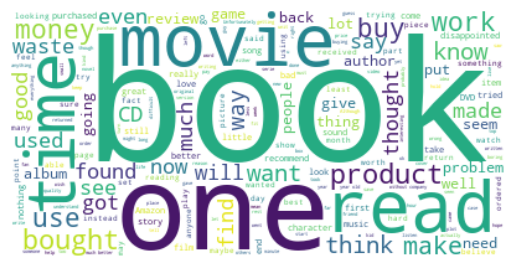

In [113]:
wordcloud = WordCloud(background_color='white').generate(negative_sentence)
plt.imshow(wordcloud, interpolation='bilinear')  
plt.axis('off')  
plt.show()  

In [114]:
positive= train[train['polarity']==1]
print(positive)

         polarity                                              title  \
0               1              The best soundtrack ever to anything.   
1               1                                           Amazing!   
2               1                               Excellent Soundtrack   
3               1  Remember, Pull Your Jaw Off The Floor After He...   
4               1                            an absolute masterpiece   
...           ...                                                ...   
3599988         1                                         Amazing CD   
3599989         1             Buy this CD and you'll thank yourself!   
3599990         1                                        Tyler Rocks   
3599991         1                                            AWESOME   
3599998         1              Makes My Blood Run Red-White-And-Blue   

                                                      text  length  
0        I'm reading a lot of reviews saying that this ...     470

In [115]:
positive_list=positive['text'].tolist()
positive_sentence="".join(positive_list)

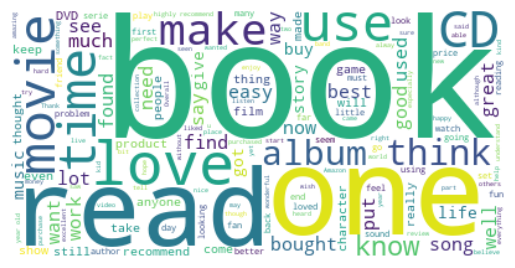

In [116]:

wordcloud = WordCloud(background_color='white').generate(positive_sentence)

plt.imshow(wordcloud, interpolation='bilinear') 
plt.axis('off') 
plt.show()  

In [117]:
def unigram_analysis(reviews, top_k=10):
    vectorizer = CountVectorizer(stop_words='english')  
    unigram_matrix = vectorizer.fit_transform(reviews)  
    
    # Sum frequencies of each unigram
    unigram_counts = unigram_matrix.sum(axis=0).A1
    unigram_features = vectorizer.get_feature_names_out()
    
    # Create a DataFrame of unigrams and their counts
    unigram_df = pd.DataFrame({'unigram': unigram_features, 'count': unigram_counts})
    unigram_df = unigram_df.sort_values(by='count', ascending=False).head(top_k)
    
    return unigram_df

In [118]:
positive_reviews = train[train['polarity'] == 1]['text']
negative_reviews = train[train['polarity'] == 0]['text']
positive_unigrams = unigram_analysis(positive_reviews, top_k=10)
negative_unigrams = unigram_analysis(negative_reviews, top_k=10)

print("Top 10 Positive Unigrams:")
print(positive_unigrams)

print("\nTop 10 Negative Unigrams:")
print(negative_unigrams)

Top 10 Positive Unigrams:
       unigram   count
88178     book  913116
249114   great  596876
332114    like  468645
245192    good  466743
307597    just  383070
458772    read  363040
339115    love  308184
565755    time  295214
459696  really  282037
375739   movie  242015

Top 10 Negative Unigrams:
        unigram   count
83836      book  887984
277695     just  524250
297425     like  522817
223290     good  375006
505819     time  337949
162315      don  334947
334227    movie  297896
409966     read  278899
410790   really  267416
396135  product  253830


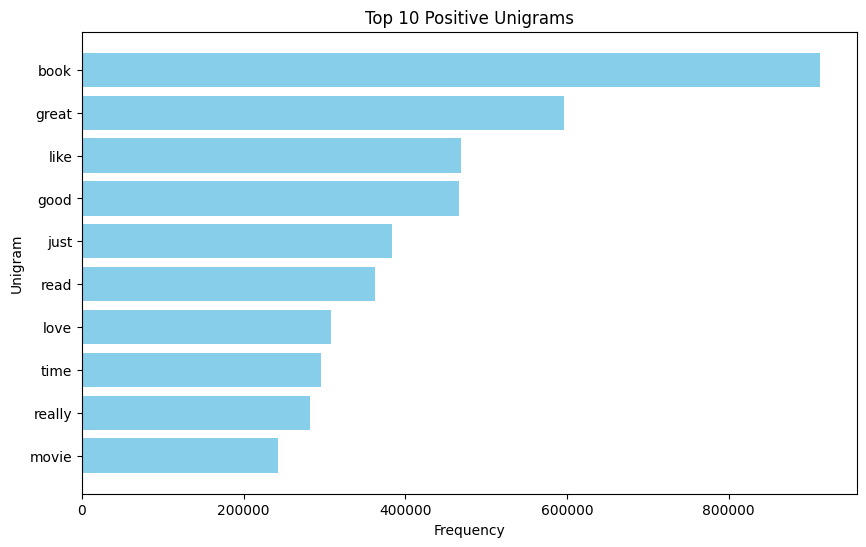

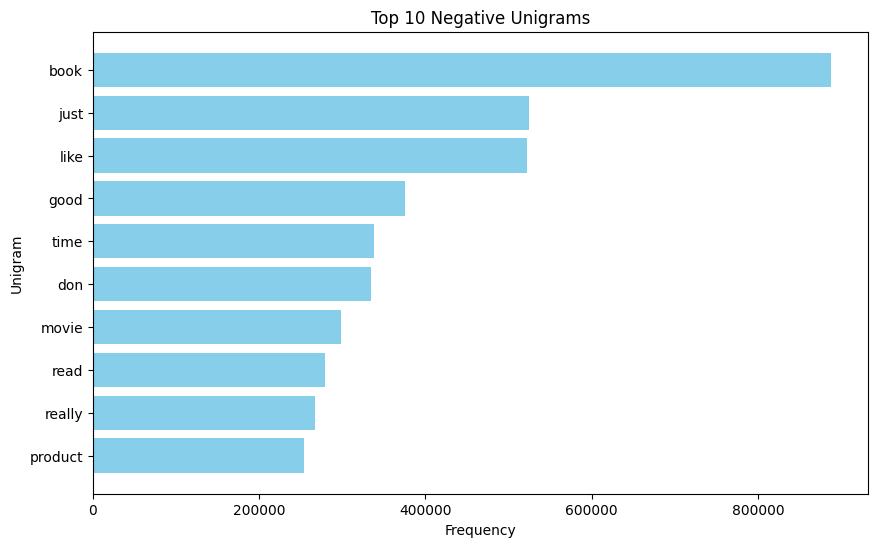

In [119]:
def plot_unigrams(unigram_df, title):
    plt.figure(figsize=(10, 6))
    plt.barh(unigram_df['unigram'], unigram_df['count'], color='skyblue')
    plt.xlabel('Frequency')
    plt.ylabel('Unigram')
    plt.title(title)
    plt.gca().invert_yaxis()  
    plt.show()

# Plot Positive Unigrams
plot_unigrams(positive_unigrams, "Top 10 Positive Unigrams")

# Plot Negative Unigrams
plot_unigrams(negative_unigrams, "Top 10 Negative Unigrams")

In [120]:
train.head()

,polarity,title,text,length
0,1,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...,470
1,1,Amazing!,This soundtrack is my favorite music of all ti...,750
2,1,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...,721
3,1,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine...",425
4,1,an absolute masterpiece,I am quite sure any of you actually taking the...,800


**DATA PREPROCESSING**


In [121]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from nltk.tokenize import RegexpTokenizer
from tqdm import tqdm
tqdm.pandas()
tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))

def fast_clean(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = [
        lemmatizer.lemmatize(word) for word in tokenizer.tokenize(text)
        if word not in stop_words and len(word) > 2
    ]
    return ' '.join(tokens)


train['cleaned_text'] = train['text'].progress_apply(fast_clean)
test['cleaned_text'] = test['text'].progress_apply(fast_clean)

100%|██████████| 399999/399999 [00:31<00:00, 12775.02it/s]


In [ ]:

train_label=train.drop(['title','text','cleaned_text'],axis=1)
test_label=test.drop(['title','text','cleaned_text'],axis=1)

In [123]:

MAX_WORD=5000
MAX_LEN=200

combined_train = train['cleaned_text']
combined_test = test['cleaned_text']

tokenizer = Tokenizer(num_words=MAX_WORD)
tokenizer.fit_on_texts(combined_train.astype(str)) 

train_sequences = tokenizer.texts_to_sequences(combined_train.astype(str))
test_sequences = tokenizer.texts_to_sequences(combined_test.astype(str))

train_sequences_matrix = pad_sequences(train_sequences, maxlen=MAX_LEN)
test_sequences_matrix = pad_sequences(test_sequences, maxlen=MAX_LEN)

In [124]:
from sklearn.model_selection import train_test_split  
x_train, x_val, y_train, y_val = train_test_split(
    train_sequences_matrix, train_label, test_size=0.2, random_state=42)


In [125]:
y_train.drop(['length'], axis=1, inplace=True)
y_val.drop(['length'], axis=1, inplace=True)




In [126]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((2879999, 200), (2879999, 1), (720000, 200), (720000, 1))

**MODEL**

In [127]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
model= Sequential()
model.add(Embedding(input_dim=MAX_WORD, output_dim=64, input_length=MAX_LEN))
model.add(SimpleRNN(64, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=5, batch_size=512, validation_data=(x_val, y_val))


Epoch 1/5
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 492s 87ms/step - accuracy: 0.8362 - loss: 0.3667 - val_accuracy: 0.8696 - val_loss: 0.3048
Epoch 2/5
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 528s 94ms/step - accuracy: 0.8714 - loss: 0.3060 - val_accuracy: 0.8757 - val_loss: 0.2949
Epoch 3/5
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 520s 92ms/step - accuracy: 0.8793 - loss: 0.2904 - val_accuracy: 0.8827 - val_loss: 0.2798
Epoch 4/5
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 1029s 183ms/step - accuracy: 0.8867 - loss: 0.2759 - val_accuracy: 0.8858 - val_loss: 0.2740
Epoch 5/5
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 874s 155ms/step - accuracy: 0.8912 - loss: 0.2668 - val_accuracy: 0.8862 - val_loss: 0.2719


In [128]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
model = Sequential()
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=MAX_WORD, output_dim=64, input_length=200))
lstm_model.add(LSTM(64)) 
lstm_model.add(Dropout(0.5))  
lstm_model.add(Dense(1, activation='sigmoid'))
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_history = lstm_model.fit(
    x_train, y_train,
    validation_split=0.1,
    epochs=5,
    batch_size=512,
    verbose=1
)
loss, accuracy = lstm_model.evaluate(x_val, y_val)
print(f"LSTM Test Accuracy: {accuracy:.4f}")

Epoch 1/5
5063/5063 ━━━━━━━━━━━━━━━━━━━━ 957s 189ms/step - accuracy: 0.8524 - loss: 0.3385 - val_accuracy: 0.8845 - val_loss: 0.2748
Epoch 2/5
5063/5063 ━━━━━━━━━━━━━━━━━━━━ 956s 189ms/step - accuracy: 0.8892 - loss: 0.2668 - val_accuracy: 0.8947 - val_loss: 0.2538
Epoch 3/5
5063/5063 ━━━━━━━━━━━━━━━━━━━━ 993s 196ms/step - accuracy: 0.8985 - loss: 0.2477 - val_accuracy: 0.8984 - val_loss: 0.2458
Epoch 4/5
5063/5063 ━━━━━━━━━━━━━━━━━━━━ 1035s 204ms/step - accuracy: 0.9042 - loss: 0.2354 - val_accuracy: 0.8997 - val_loss: 0.2452
Epoch 5/5
5063/5063 ━━━━━━━━━━━━━━━━━━━━ 1276s 252ms/step - accuracy: 0.9091 - loss: 0.2255 - val_accuracy: 0.9012 - val_loss: 0.2410
22500/22500 ━━━━━━━━━━━━━━━━━━━━ 174s 8ms/step - accuracy: 0.9011 - loss: 0.2397
LSTM Test Accuracy: 0.9014


In [130]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout


gru_model = Sequential()
gru_model.add(Embedding(input_dim=MAX_WORD, output_dim=64, input_length=200))
gru_model.add(GRU(64))  
gru_model.add(Dropout(0.5))
gru_model.add(Dense(1, activation='sigmoid'))

gru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


gru_history = gru_model.fit(
    x_train, y_train,
    validation_split=0.1,
    epochs=5,
    batch_size=1024,
    verbose=1
)


loss, accuracy = gru_model.evaluate(x_val,y_val)
print(f"GRU Test Accuracy: {accuracy:.4f}")


Epoch 1/5
2532/2532 ━━━━━━━━━━━━━━━━━━━━ 833s 328ms/step - accuracy: 0.8386 - loss: 0.3624 - val_accuracy: 0.8827 - val_loss: 0.2775
Epoch 2/5
2532/2532 ━━━━━━━━━━━━━━━━━━━━ 1296s 512ms/step - accuracy: 0.8864 - loss: 0.2725 - val_accuracy: 0.8902 - val_loss: 0.2623
Epoch 3/5
2532/2532 ━━━━━━━━━━━━━━━━━━━━ 1329s 525ms/step - accuracy: 0.8940 - loss: 0.2565 - val_accuracy: 0.8931 - val_loss: 0.2573
Epoch 4/5
2532/2532 ━━━━━━━━━━━━━━━━━━━━ 838s 331ms/step - accuracy: 0.8988 - loss: 0.2461 - val_accuracy: 0.8967 - val_loss: 0.2487
Epoch 5/5
2532/2532 ━━━━━━━━━━━━━━━━━━━━ 854s 337ms/step - accuracy: 0.9030 - loss: 0.2370 - val_accuracy: 0.8986 - val_loss: 0.2472
22500/22500 ━━━━━━━━━━━━━━━━━━━━ 147s 7ms/step - accuracy: 0.8987 - loss: 0.2454
GRU Test Accuracy: 0.8990
